SVHN

[Google Street View House Number(SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/)

Much similar to MNIST(images of cropped digits), but SVHN contains much more labeled data (over 600,000 images) with real world problems of recognizing digits and numbers in *natural scene images*.

**Overview:**

1) Total 10 Classes, 1 for each digits i.e Label '9' for digit 9 and '10' for digit 0. 

2) 73,257 digits for training, 26,032 digits for testing.

3) Available in two differnet formats
Original images with bounding box available for each character (may contain multiple characters in same images).

MNIST like 32x32 cropped images having single character in each images.
Dataset is obtained from house numbers in Google Street View images.

Here we are classifying 32 x 32 cropped images given in format 2

In [1]:
import os
import tarfile
import torch
import numpy as np

import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

import torch.nn as nn
from torch.nn import AvgPool2d
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

!pip install torchsummary
from torchsummary import summary

from scipy.io import loadmat

In [2]:
root='http://ufldl.stanford.edu/housenumbers/'

transform = transforms.Compose([
                                transforms.CenterCrop((28, 28)),
                                transforms.ToTensor(),
                                #transforms.Normalize([0.5,],[0.5,])
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                                ])

train = torchvision.datasets.SVHN(root, split='train', transform=transform, target_transform=None, download=True)

train_dl = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

test_vi = torchvision.datasets.SVHN(root, split='test', transform=transforms.ToTensor(),download=True)
test_vii = torch.utils.data.DataLoader(test_vi, batch_size=128, shuffle=True)

test = torchvision.datasets.SVHN(root, split='test', transform=transform, target_transform=None, download=True)

test_dl = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

images_train, labels_train = next(iter(train_dl))
images_test, labels_test = next(iter(test_dl))
images_test_vi, labels_test_vi = next(iter(test_vi))

print("Shape of train inputs: ", images_train.shape, "; Shape of train labels: ", labels_train.shape)
print("Shape of test inputs: ",images_test.shape, "; Shape of test inputs: ", labels_test.shape)
print("Batch size = 128")

Using downloaded and verified file: http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Shape of train inputs:  torch.Size([128, 3, 28, 28]) ; Shape of train labels:  torch.Size([128])
Shape of test inputs:  torch.Size([128, 3, 28, 28]) ; Shape of test inputs:  torch.Size([128])
Batch size = 128


In [3]:
def show(image):
  ig, axes = plt.subplots()
  plt.imshow(image)

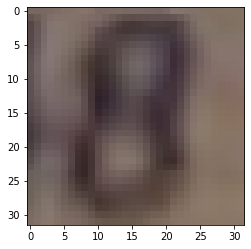

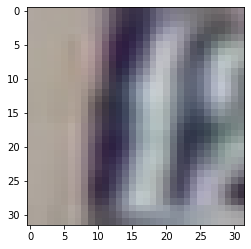

In [4]:
dataiter = iter(test_vii)
images, labels = dataiter.next()
for i in range(113,115):
  img = images[i]
  img = img.numpy().transpose((1, 2, 0))
  show(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


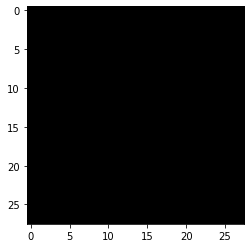

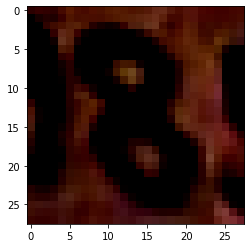

In [5]:
dataiter = iter(test_dl)
images, labels = dataiter.next()
for i in range(113,115):
  img = images[i]
  img = img.numpy().transpose((1, 2, 0))
  show(img)

In [6]:
img, label = train[0]
print(img.shape, label)
img

torch.Size([3, 28, 28]) 1


tensor([[[-0.8745, -0.7647, -0.4980,  ..., -0.7412, -0.8039, -0.8196],
         [-0.8196, -0.8196, -0.5373,  ..., -0.6471, -0.5294, -0.6157],
         [-0.8275, -0.8588, -0.5922,  ..., -0.4745, -0.3569, -0.4039],
         ...,
         [-0.3569, -0.4431, -0.8196,  ..., -0.3333, -0.2078, -0.2000],
         [-0.3961, -0.4275, -0.6863,  ..., -0.2078, -0.1922, -0.1765],
         [-0.3569, -0.3725, -0.5137,  ..., -0.1765, -0.1843, -0.1843]],

        [[-0.8667, -0.7490, -0.5137,  ..., -0.8353, -0.7569, -0.7725],
         [-0.8588, -0.8039, -0.5451,  ..., -0.6314, -0.5843, -0.6627],
         [-0.8353, -0.8353, -0.5608,  ..., -0.4431, -0.4275, -0.4667],
         ...,
         [-0.4039, -0.4980, -0.8353,  ..., -0.2941, -0.2392, -0.2078],
         [-0.3647, -0.4196, -0.7020,  ..., -0.2314, -0.2000, -0.1843],
         [-0.3804, -0.3961, -0.5059,  ..., -0.1843, -0.1843, -0.1843]],

        [[-0.8196, -0.7647, -0.5765,  ..., -0.6471, -0.6941, -0.6471],
         [-0.8039, -0.8118, -0.5922,  ..., -0

In [7]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


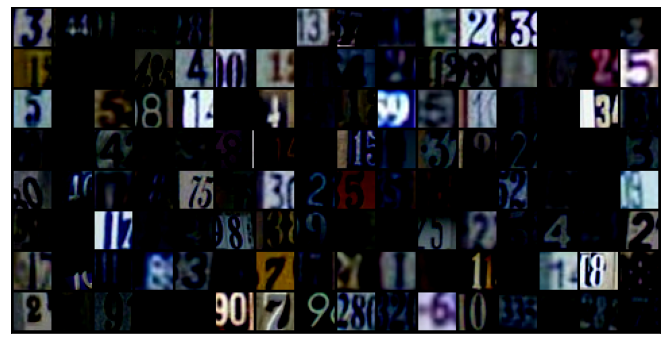

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [15]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [16]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
input_size = 2352
num_classes = 10

## Logistic Regression

In [17]:
class LogisticModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 2352)
        out = self.linear(xb)
        return out

In [18]:
model1 = LogisticModel()

In [19]:
print(sum(p.numel() for p in model1.parameters()))
print(sum(p.numel() for p in model1.parameters() if p.requires_grad))

23530
23530


In [20]:
history1 = evaluate(model1, test_dl)
history1

{'val_acc': 0.09842218458652496, 'val_loss': 2.3205020427703857}

In [21]:
%%time
history1 = fit(num_epochs, lr, model1, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 2.2358, val_loss: 2.3091, val_acc: 0.1969
Epoch [1], train_loss: 2.1942, val_loss: 2.2974, val_acc: 0.1971
Epoch [2], train_loss: 2.1799, val_loss: 2.2666, val_acc: 0.2329
Epoch [3], train_loss: 2.1782, val_loss: 2.3029, val_acc: 0.2200
Epoch [4], train_loss: 2.1741, val_loss: 2.2924, val_acc: 0.2161
Epoch [5], train_loss: 2.1728, val_loss: 2.2998, val_acc: 0.2138
Epoch [6], train_loss: 2.1682, val_loss: 2.3094, val_acc: 0.2199
Epoch [7], train_loss: 2.1668, val_loss: 2.3397, val_acc: 0.2163
Epoch [8], train_loss: 2.1632, val_loss: 2.3099, val_acc: 0.2240
Epoch [9], train_loss: 2.1622, val_loss: 2.3053, val_acc: 0.2262
CPU times: user 4min 38s, sys: 616 ms, total: 4min 38s
Wall time: 4min 39s


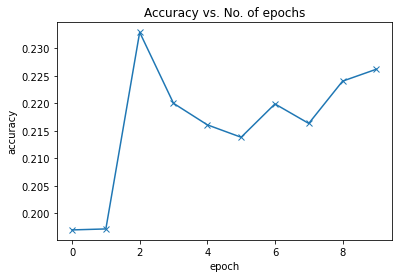

In [22]:
plot_accuracies(history1)

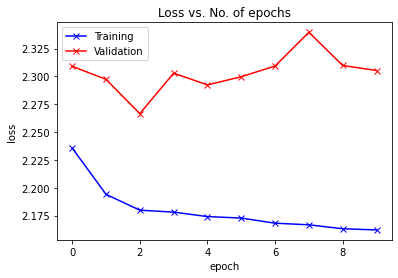

In [23]:
plot_losses(history1)

In [24]:
torch.save(model1.state_dict(), 'svhn_logistic.pth')

## Feed Forward Neural Network

In [25]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(test_dl, device)

In [26]:
class FeedFwdModel(ImageClassificationBase):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 16)
        # hidden layer 2
        self.linear2 = nn.Linear(16, 32)
        # output layer
        self.linear3 = nn.Linear(32, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out

In [27]:
model2 = FeedFwdModel(input_size, out_size=num_classes)
model2 = to_device(model2, device)

In [28]:
summary(model2, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]          37,648
            Linear-2                   [-1, 32]             544
            Linear-3                   [-1, 10]             330
Total params: 38,522
Trainable params: 38,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [29]:
print(sum(p.numel() for p in model2.parameters()))
print(sum(p.numel() for p in model2.parameters() if p.requires_grad))

38522
38522


In [30]:
history2 = [evaluate(model2, val_dl)]
history2

[{'val_acc': 0.09177134186029434, 'val_loss': 2.3075408935546875}]

In [31]:
%%time
history2 = fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.5366, val_loss: 1.3071, val_acc: 0.5936
Epoch [1], train_loss: 1.1023, val_loss: 1.1898, val_acc: 0.6383
Epoch [2], train_loss: 1.0267, val_loss: 1.1384, val_acc: 0.6614
Epoch [3], train_loss: 0.9845, val_loss: 1.0997, val_acc: 0.6779
Epoch [4], train_loss: 0.9520, val_loss: 1.1037, val_acc: 0.6782
Epoch [5], train_loss: 0.9328, val_loss: 1.0888, val_acc: 0.6783
Epoch [6], train_loss: 0.9178, val_loss: 1.0615, val_acc: 0.6895
Epoch [7], train_loss: 0.8989, val_loss: 1.0688, val_acc: 0.6884
Epoch [8], train_loss: 0.8918, val_loss: 1.0721, val_acc: 0.6903
Epoch [9], train_loss: 0.8797, val_loss: 1.0813, val_acc: 0.6836
CPU times: user 4min 51s, sys: 870 ms, total: 4min 52s
Wall time: 4min 53s


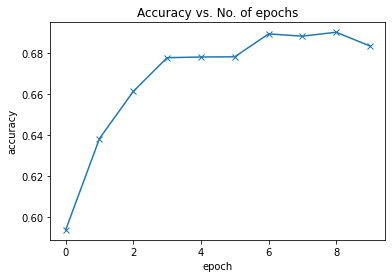

In [32]:
plot_accuracies(history2)

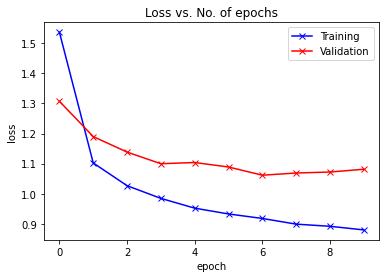

In [33]:
plot_losses(history2)

In [34]:
torch.save(model2.state_dict(), 'svhn_feedfwd.pth')

## Convolution Neural Net + Feed Forward Net

In [35]:
class CnnFnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14
            nn.Dropout(p=0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 7 x 7
            nn.Dropout(p=0.25),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 1024 x 3 x 3
            nn.Dropout(p=0.25),

            nn.Flatten(), 
            nn.Linear(1024*3*3, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            #nn.Dropout(p=0.25),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [36]:
model3 = CnnFnnModel()
model3

CnnFnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25,

In [37]:
model3 = to_device(CnnFnnModel(), device)

In [38]:
summary(model3, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          18,496
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]          73,856
      BatchNorm2d-10          [-1, 128, 14, 14]             256
             ReLU-11          [-1, 128, 14, 14]               0
           Conv2d-12          [-1, 256, 14, 14]         295,168
      BatchNorm2d-13          [-1, 256, 14, 14]             512
             ReLU-14          [-1, 256,

In [39]:
print(sum(p.numel() for p in model3.parameters()))
print(sum(p.numel() for p in model3.parameters() if p.requires_grad))

16263434
16263434


In [40]:
history3 = evaluate(model3, val_dl)
history3

{'val_acc': 0.09174581617116928, 'val_loss': 2.3004884719848633}

In [41]:
%%time
history3 = fit(num_epochs, lr, model3, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.5886, val_loss: 0.3015, val_acc: 0.9138
Epoch [1], train_loss: 0.2851, val_loss: 0.2304, val_acc: 0.9322
Epoch [2], train_loss: 0.2306, val_loss: 0.2118, val_acc: 0.9403
Epoch [3], train_loss: 0.1980, val_loss: 0.1981, val_acc: 0.9430
Epoch [4], train_loss: 0.1729, val_loss: 0.1894, val_acc: 0.9467
Epoch [5], train_loss: 0.1520, val_loss: 0.1911, val_acc: 0.9477
Epoch [6], train_loss: 0.1314, val_loss: 0.1847, val_acc: 0.9494
Epoch [7], train_loss: 0.1172, val_loss: 0.1926, val_acc: 0.9473
Epoch [8], train_loss: 0.0987, val_loss: 0.2092, val_acc: 0.9471
Epoch [9], train_loss: 0.0861, val_loss: 0.2024, val_acc: 0.9491
CPU times: user 10min 23s, sys: 2min 55s, total: 13min 18s
Wall time: 13min 20s


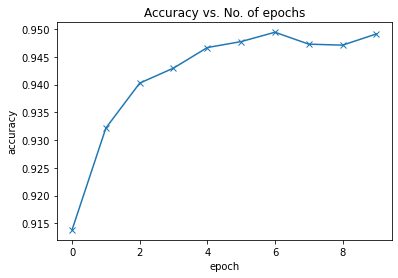

In [42]:
plot_accuracies(history3)

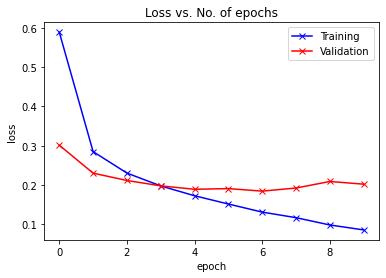

In [43]:
plot_losses(history3)

In [44]:
torch.save(model3.state_dict(), 'svhn_cnnfnn.pth')

## Convolutional Neural Network

In [45]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 16, kernel_size=1, stride=1, padding=0),
            nn.MaxPool2d(2, 2), # output: 16 x 14 x 14
            nn.Dropout(p=0.25),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 10, kernel_size=1, stride=1, padding=1),
            #nn.MaxPool2d(2, 2), # output: 10 x 3 x 3

            nn.AvgPool2d(kernel_size=6),           
            nn.Flatten(),
            nn.Softmax())
        
    def forward(self, xb):
        return self.network(xb)

In [46]:
model4 = CnnModel()
model4

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.25, inplace=False)
    (16): Conv2d(16, 32, kernel_size=(3, 3), strid

In [47]:
model4 = to_device(CnnModel(), device)

In [48]:
summary(model4, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             448
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          18,496
              ReLU-8           [-1, 64, 28, 28]               0
            Conv2d-9          [-1, 128, 28, 28]          73,856
      BatchNorm2d-10          [-1, 128, 28, 28]             256
             ReLU-11          [-1, 128, 28, 28]               0
           Conv2d-12          [-1, 256, 28, 28]         295,168
             ReLU-13          [-1, 256, 28, 28]               0
           Conv2d-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [49]:
print(sum(p.numel() for p in model4.parameters()))
print(sum(p.numel() for p in model4.parameters() if p.requires_grad))

792442
792442


In [50]:
history4 = evaluate(model4, val_dl)
history4

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'val_acc': 0.1595945805311203, 'val_loss': 2.302393913269043}

In [51]:
%%time
history4 = fit(num_epochs, lr, model4, train_dl, val_dl, opt_func)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [0], train_loss: 1.6944, val_loss: 1.5676, val_acc: 0.9012
Epoch [1], train_loss: 1.5691, val_loss: 1.5508, val_acc: 0.9178
Epoch [2], train_loss: 1.5543, val_loss: 1.5439, val_acc: 0.9205
Epoch [3], train_loss: 1.5481, val_loss: 1.5471, val_acc: 0.9162
Epoch [4], train_loss: 1.5426, val_loss: 1.5323, val_acc: 0.9308
Epoch [5], train_loss: 1.5373, val_loss: 1.5314, val_acc: 0.9314
Epoch [6], train_loss: 1.5340, val_loss: 1.5261, val_acc: 0.9363
Epoch [7], train_loss: 1.5315, val_loss: 1.5238, val_acc: 0.9389
Epoch [8], train_loss: 1.5266, val_loss: 1.5207, val_acc: 0.9421
Epoch [9], train_loss: 1.5263, val_loss: 1.5238, val_acc: 0.9386
CPU times: user 10min 41s, sys: 3min 3s, total: 13min 45s
Wall time: 13min 47s


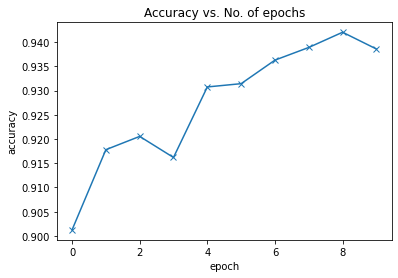

In [52]:
plot_accuracies(history4)

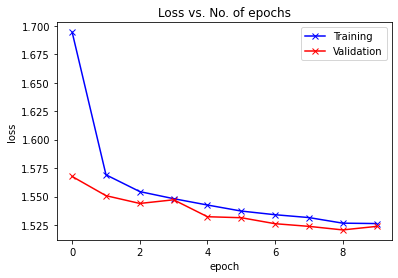

In [53]:
plot_losses(history4)

In [54]:
torch.save(model4.state_dict(), 'svhn_cnn.pth')

## ResNet

In [55]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [56]:
model5 = to_device(ResNet(3, 10), device)
model5

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [57]:
summary(model5, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,792
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 128, 28, 28]          73,856
       BatchNorm2d-5          [-1, 128, 28, 28]             256
              ReLU-6          [-1, 128, 28, 28]               0
         MaxPool2d-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]         147,584
       BatchNorm2d-9          [-1, 128, 14, 14]             256
             ReLU-10          [-1, 128, 14, 14]               0
           Conv2d-11          [-1, 128, 14, 14]         147,584
      BatchNorm2d-12          [-1, 128, 14, 14]             256
             ReLU-13          [-1, 128, 14, 14]               0
           Conv2d-14          [-1, 256,

In [58]:
print(sum(p.numel() for p in model5.parameters()))
print(sum(p.numel() for p in model5.parameters() if p.requires_grad))

6575370
6575370


In [59]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [60]:
history5 = [evaluate(model5, val_dl)]
history5

[{'val_acc': 0.0912351906299591, 'val_loss': 2.3085780143737793}]

In [61]:
grad_clip = 0.1
weight_decay = 1e-4

In [62]:
%%time
history5 = fit_one_cycle(num_epochs, lr, model5, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 0.7483, val_loss: 0.4389, val_acc: 0.8626
Epoch [1], train_loss: 0.3013, val_loss: 0.3314, val_acc: 0.9033
Epoch [2], train_loss: 0.2425, val_loss: 0.3084, val_acc: 0.9095
Epoch [3], train_loss: 0.1897, val_loss: 0.2684, val_acc: 0.9227
Epoch [4], train_loss: 0.1499, val_loss: 0.2228, val_acc: 0.9365
Epoch [5], train_loss: 0.1090, val_loss: 0.2114, val_acc: 0.9441
Epoch [6], train_loss: 0.0612, val_loss: 0.1882, val_acc: 0.9526
Epoch [7], train_loss: 0.0196, val_loss: 0.1811, val_acc: 0.9564
Epoch [8], train_loss: 0.0040, val_loss: 0.1747, val_acc: 0.9595
Epoch [9], train_loss: 0.0019, val_loss: 0.1751, val_acc: 0.9595
CPU times: user 15min, sys: 6min 38s, total: 21min 39s
Wall time: 21min 42s


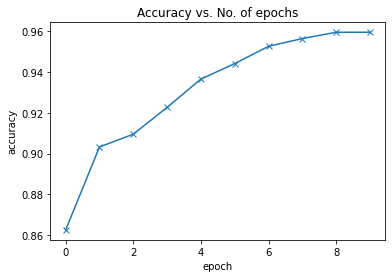

In [63]:
plot_accuracies(history5)

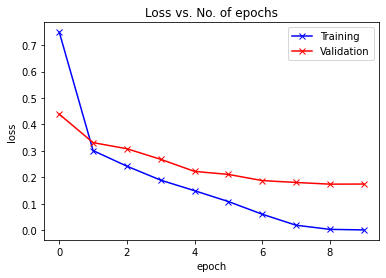

In [64]:
plot_losses(history5)

In [65]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

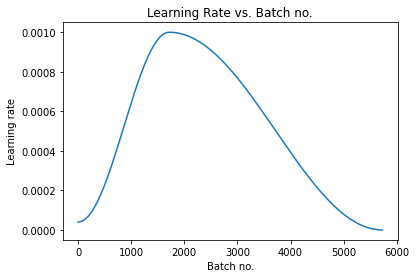

In [66]:
plot_lrs(history5)

In [67]:
torch.save(model5.state_dict(), 'svhn_resnet9.pth')

### Results

In [68]:
result1 = evaluate(model1, test_dl)
print(result1)
result2 = evaluate(model2, val_dl)
print(result2)
result3 = evaluate(model3, val_dl)
print(result3)
result4 = evaluate(model4, val_dl)
print(result4)
result5 = evaluate(model5, val_dl)
print(result5)

{'val_loss': 2.3054263591766357, 'val_acc': 0.22657527029514313}
{'val_loss': 1.0804352760314941, 'val_acc': 0.6836192607879639}
{'val_loss': 0.2019946426153183, 'val_acc': 0.9492442607879639}


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'val_loss': 1.5235928297042847, 'val_acc': 0.9387893080711365}
{'val_loss': 0.17538809776306152, 'val_acc': 0.9593673348426819}


## Summary

| SNo | Model | Linear/Conv Layers | Optimizer | Batch Size | Learning Rate | Parameters | Epochs | Time | Validation Accuracy |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| 1 | Logistic Regression | None | Adam | None | 0.001 | 23.5 k | 10 | 4m 39s | 0.2265| 
| 2 | FFNN | 3 | Adam | 128 | 0.001 | 38.5 k | 10 | 4m 53s | 0.6836 | 
| 3 | CNN + FFNN | 12 | Adam | 128 | 0.001 | 16.2 M | 10 | 13m 20s | 0.9492 |
| 4 | CNN | 12 | Adam | 128 | 0.001 | 792 k | 10 | 13m 47s | 0.9387 |
| 5 | Resnet | 12 | Adam | 128 | 0.0001-0.001 | 6.5 M | 10 | 21m 42s | 0.9593 |